In [1]:
from yolov3 import YoloV3Net
import torch
import pandas

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print('Loading network.....')
model = YoloV3Net('cfg/yolov3.cfg')
model.load_weights('weights/yolov3.weights')
model.net_info['height'] = '416'
model.eval()
CUDA = torch.cuda.is_available()
print('Network successfully loaded')

Loading network.....
Network successfully loaded


In [3]:
from util import load_classes
classes = load_classes('data/coco.names')

In [165]:
import pandas as pd
from PIL import ImageDraw, Image
import os
from util import load_classes

def get_annotation_bbox(image_file, size, box_format='midpoint'):
    annotation_file = os.path.join('coco128', 'labels', 'train2017', f'{image_file}.txt')
    if annotation_file is None or not os.path.isfile(annotation_file):
        return None
    w, h = size
    bboxes = []

    with open(annotation_file) as f:
        for line in f.readlines():
            label, xmin, ymin, width, height = line.split()
            label_name = classes[int(label)]
            width = float(width) * w
            height = float(height) * h
            p1 = (float(xmin) * w - width / 2, float(ymin) * h - height / 2)
            p2 = (float(xmin) * w + width / 2, float(ymin) * h + height / 2)
            if box_format == 'midpoint':
                bboxes.append((p1, p2, label_name))
            elif box_format == 'corner':
                bboxes.append([0, int(label), 1, p1[0], p1[1], p2[0], p2[1]])
    return bboxes

def draw_bbox(image, bbox):
    p1, p2, label = bbox
    image_draw = ImageDraw.Draw(image)
    image_draw.rectangle((p1, p2), outline ="purple", width=3)
    image_draw.text((p1[0], p2[1]), label)

classes = load_classes('data/coco.names')
bbox_dict = dict()
dir = os.path.join('coco128', 'images', 'train2017')
for i,image_file in enumerate(os.listdir(dir)):
    image = Image.open(os.path.join(dir, image_file))
    bboxes = get_annotation_bbox(image_file[:-4], image.size)
    if bboxes is not None:
        bbox_dict[image_file] = bboxes
        for bbox in bboxes:
            draw_bbox(image, bbox)
    # if i % 10 == 0:
    #     print(bboxes[0])
    #     display(image)

In [166]:
from torch.autograd import Variable
from preprocess import prep_image
from util import write_results

confidence = 0.4
nms_thresh = 0.4

preds = []
target = []
for i,image_file in enumerate(os.listdir(dir)):
    image_path = os.path.join(dir, image_file)
    image, orig_im, dim = prep_image(image_path, int(model.net_info['height']))
    bboxes = get_annotation_bbox(image_file[:-4], dim, box_format='corner')
    # if bboxes is None:
    #     print(bboxes, image_path)
    for bbox in bboxes:
        bbox[0] = i
        target.append(bbox)
    with torch.no_grad():
        output = model(Variable(image), CUDA)
        predictions = write_results(output, confidence, len(classes), nms=True, nms_conf=nms_thresh)
        if i == 0:
            print(predictions)
        img = Image.open(image_path)
        for prediction in predictions:
            inp_dim = int(model.net_info['height'])
            xmin, ymin, width, height = [int(p) for p in prediction[1:5]]
            acopy = xmin, ymin, width, height
            w, h = img.size
            scale = min([inp_dim / w, inp_dim / h, 1])
            # scale_y = min(inp_dim / h, 1)
            # scale_y = scale_x
            xmin = (xmin - (inp_dim - scale * w) / 2) / scale
            ymin = (ymin - (inp_dim - scale * h) / 2) / scale
            width = (width - (inp_dim - scale * w) / 2) / scale
            height = (height - (inp_dim - scale * h) / 2) / scale

            label, probability = prediction[-1], prediction[5]
            preds.append([i, label, probability, xmin, ymin, width, height])
            p1, p2 = (xmin, ymin), (width, height)
            draw_bbox(img, (p1, p2, classes[int(label)]))
            if i == 10:
                # print(p1, p2, classes[int(label)])
                # print(acopy)
                # print('scale_x:', scale_x)
                # print('scale_y:', min(inp_dim / h, 1))
                print(xmin, ymin, width, height, classes[int(label)], int(label))
        # display(img)
            
        # print('Detected:', ', '.join([classes[int(prediction[-1].item())] for prediction in predictions]))
        

# [train_idx, class_prediction, prob_score, x1, y1, x2, y2]

tensor([[  0.0000,  70.3909, 184.7525, 360.3696, 359.3018,   0.9926,   0.9435,
          59.0000],
        [  0.0000, 117.3358, 177.2934, 183.5455, 235.0699,   0.9092,   0.9986,
          77.0000],
        [  0.0000, 257.2002, 234.5681, 344.2063, 302.7865,   0.7926,   0.9919,
          77.0000],
        [  0.0000, 168.3815, 238.0337, 211.4769, 288.4330,   0.5812,   0.9978,
          77.0000],
        [  0.0000, 202.2441, 219.7743, 257.4915, 284.2765,   0.4644,   0.9944,
          77.0000]])
148.8846153846154 43.07692307692307 284.2692307692308 609.2307692307692 person 0
58.11538461538462 247.69230769230768 196.57692307692307 601.5384615384615 person 0
290.4230769230769 378.46153846153845 425.80769230769226 587.6923076923076 suitcase 28


In [109]:
preds[0], target[0], classes[52], classes[54]

([0,
  59.0,
  0.9926375150680542,
  0.0,
  70.39088439941406,
  184.75253295898438,
  360.36956787109375],
 [2, 54, 1, 480.0, 197.38992, 600.81024, 312.80976],
 'hot dog',
 'donut')

In [90]:
model

YoloV3Net(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bat

117.84032000000002 235.14 543.78016 475.14
70 184 360 359
70 184 360 359
107.6923076923077 203.07692307692307 553.8461538461538 472.30769230769226


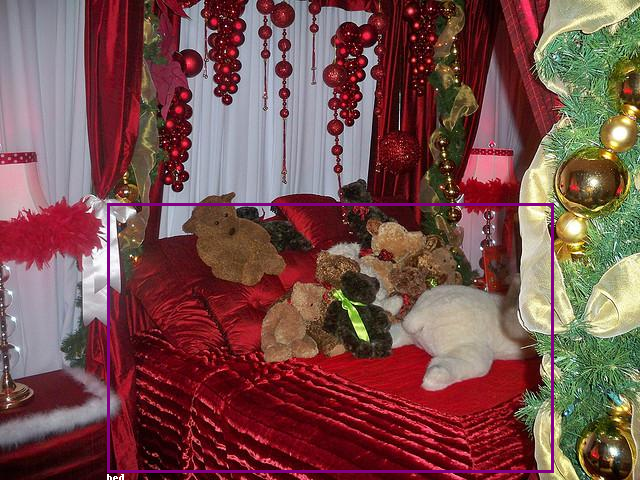

In [141]:
import cv2
%matplotlib inline
from matplotlib import pyplot as plt

path = os.path.join('coco128', 'images', 'train2017', '000000000612.jpg')
img = Image.open(path)

# p1 = (float(xmin) * w - width / 2, float(ymin) * h - height / 2)
# p2 = (float(xmin) * w + width / 2, float(ymin) * h + height / 2)

xmin, ymin, width, height = [int(p) for p in preds[0][3:7]]
xmint, ymint, widtht, heightt = target[0][3:7]
print(xmint, ymint, widtht, heightt)
p1_preds = tuple([ymin, xmin])
p2_preds = tuple([height, width])
print(xmin, ymin, width, height)
# print(xmin * 1.7, ymin * 1.7, width * 1.7, height * 1.7)

# width = float(width) * w
# height = float(height) * h
# p1 = (float(xmin) * w - width / 2, float(ymin) * h - height / 2)
# p2 = (float(xmin) * w + width / 2, float(ymin) * h + height / 2)
inp_dim = int(model.net_info['height'])
w, h = img.size
img_c = cv2.imread(path)
# scaling_factor = inp_dim# torch.min(inp_dim/im_dim_list,1)[0].view(-1,1)
# output[:,[1,3]] -= (inp_dim - scaling_factor*im_dim_list[:,0].view(-1,1))/2
# # output[:,[2,4]] -= (inp_dim - scaling_factor*im_dim_list[:,1].view(-1,1))/2
scale_x = min(inp_dim / w, 1)
scale_y = min(inp_dim / h, 1)
scale_y = scale_x
print(xmin, ymin, width, height)
xmin = (xmin - (inp_dim - scale_x * w) / 2) / scale_x
ymin = (ymin - (inp_dim - scale_y * h) / 2) / scale_y
width = (width - (inp_dim - scale_x * w) / 2) / scale_x
height = (height - (inp_dim - scale_y * h) / 2) / scale_y
print(xmin, ymin, width, height)
# cv2.rectangle(img_c, (width, height), (width + xmin * 2, height + 10), (255,0,0), 2)
# plt.imshow(img_c)
# plt.show()


img = Image.open(path)
# draw_bbox(img, ((108, 204), (554, 472), 'pred'))
draw_bbox(img, ((xmin, ymin), (width, height), 'bed'))

p1 = tuple(target[0][3:5])
p2 = tuple(target[0][5:7])
# draw_bbox(img, (p1, p2, 'actual'))
display(img)

In [52]:
target[0], preds[0]

([0, 59, 1, 117.84032000000002, 235.14, 543.78016, 475.14],
 [0,
  59.0,
  0.9926375150680542,
  0.0,
  70.39088439941406,
  184.75253295898438,
  360.36956787109375])

In [74]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
preds = [
    dict(
        boxes=torch.tensor([[258.0, 41.0, 606.0, 285.0], [258.0, 41.0, 606.0, 285.0]]),
        scores=torch.tensor([0.536, 0.678]),
        labels=torch.tensor([0, 1]),
    ), 
    dict(
        boxes=torch.tensor([[258.0, 41.0, 606.0, 285.0]]),
        scores=torch.tensor([0.536]),
        labels=torch.tensor([0]),
    ),
    dict(
        boxes=torch.tensor([[258.0,141.0, 506.0, 385.0]]),
        scores=torch.tensor([0.636]),
        labels=torch.tensor([1]),
    )
]
target = [
    dict(
        boxes=torch.tensor([[214.0, 41.0, 562.0, 285.0], [214.0, 41.0, 562.0, 285.0]]),
        labels=torch.tensor([0, 1]),
    ),
    dict(
        boxes=torch.tensor([[214.0, 41.0, 562.0, 285.0]]),
        labels=torch.tensor([0]),
    ),
    dict(
        boxes=torch.tensor([[114.0, 141.0, 662.0, 385.0]]),
        labels=torch.tensor([0]),
    ),
]

metric = MeanAveragePrecision()
metric.update(preds, target)
from pprint import pprint
pprint(metric.compute())

{'map': tensor(0.4990),
 'map_50': tensor(0.8317),
 'map_75': tensor(0.8317),
 'map_large': tensor(0.4990),
 'map_medium': tensor(-1.),
 'map_per_class': tensor(-1.),
 'map_small': tensor(-1.),
 'mar_1': tensor(0.5000),
 'mar_10': tensor(0.5000),
 'mar_100': tensor(0.5000),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.5000),
 'mar_medium': tensor(-1.),
 'mar_small': tensor(-1.)}


In [ ]:
from torchvision.datasets.coco import CocoDetection

dataset = CocoDetection()

In [167]:
from collections import defaultdict, Counter
from iou import intersection_over_union

def mean_average_precision(pred_boxes, true_boxes, iou_thresh=0.5, box_format='midpoint', num_classes=20):
    '''
    Calculates mean average precision.

    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
            specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones
        iou_thresh (float): threshold where predicted bboxes is correct
        box_format (str): 'midpoint' or 'corners' used to specify bboxes
        num_classes (int): number of classes
    
    Returns:
        float: mAP value across all classes given a specific IoU threshold
    '''
    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    count = defaultdict(int)

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets, and only add the ones
        # that belong to the current class c.
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)
        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)
        # count[len(ground_truths) > 0] += 1

        # Find the amount of bboxes for each training example
        # defaultdict finds how many ground truth bboxes we get for each training example
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary and convert to
        # the following (w.r.t. same example):
        # amount_bboxes = {0:torch.tensor[0,0,0]. 1:torch.tensor[0,0,0,0,0]}
        for key,val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # Sort by box probabilities (index 2)
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for di, detection in enumerate(detections):
            # Only take out the ground_truths that have the same training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for gi, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_i = gi

            if best_iou > iou_thresh:
                # only detect gorund truth detection once
                if amount_bboxes[detection[0]][best_gt_i] == 0:
                    # True positive and add this bounding box to seen
                    TP[di] = 1
                    amount_bboxes[detection[0]][best_gt_i] = 1
                else:
                    FP[di] = 1
            # If IOU is lower than the detection is a false positive
            else:
                FP[di] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))
    
    return sum(average_precisions) / len(average_precisions)

mean_average_precision(
    pred_boxes=preds,
    true_boxes=target,
    iou_thresh=0.5,
    box_format='corners',
    num_classes=len(classes)
)

tensor(0.5391)

In [73]:
target[0]

[0, 59, 117.84032000000002, 235.14, 543.78016, 475.14]

In [76]:
preds[0]

[0,
 59.0,
 0.9926375150680542,
 0.0,
 70.39088439941406,
 184.75253295898438,
 360.36956787109375]